# Pivot Tables

Hemos visto cómo la abstracción ``GroupBy`` nos permite explorar las relaciones dentro de un conjunto de datos.

Una *tabla pivotante* es una operación similar que suele verse en hojas de cálculo y otros programas que operan con datos tabulares.

La tabla pivotante toma como entrada datos simples ordenados por columnas y agrupa las entradas en una tabla bidimensional que proporciona un resumen multidimensional de los datos.

La diferencia entre las tablas pivotantes y ``GroupBy`` a veces puede causar confusión; a mí me ayuda pensar en las tablas pivotantes como una versión *multidimensional* de la agregación ``GroupBy``.

Es decir, divides-aplicas-combinas, pero tanto la división como la combinación no tienen lugar en un índice unidimensional, sino en una rejilla bidimensional.

## Tablas dinámicas motivadoras

Para los ejemplos de esta sección, utilizaremos la base de datos de pasajeros del *Titanic*, disponible a través de la librería Seaborn (ver [Visualization With Seaborn](14_Visualization-With-Seaborn.ipynb)):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
titanic['survived'].sum()

342

In [10]:
titanic.groupby('sex')[['survived']].sum()

,survived
sex,
female,233
male,109


Contiene abundante información sobre cada pasajero de aquel malogrado viaje: sexo, edad, clase, tarifa pagada y mucho más.

## Tablas dinámicas a mano

Para empezar a aprender más sobre estos datos, podríamos empezar agrupando según el género, el estado de supervivencia o alguna combinación de los mismos.
Si ha leído la sección anterior, puede verse tentado a aplicar una operación ``GroupBy``; por ejemplo, veamos la tasa de supervivencia por género:

In [12]:
titanic.groupby('sex')[['survived']].aggregate(['mean', 'sum'])

survived     
            mean  sum
sex                  
female  0.742038  233
male    0.188908  109

Esto nos da inmediatamente una idea: en general, tres de cada cuatro mujeres a bordo sobrevivieron, ¡mientras que sólo uno de cada cinco hombres sobrevivió!

Esto es útil, pero podríamos ir un paso más allá y analizar la supervivencia por sexo y, digamos, por clase.
Usando el vocabulario de ``GroupBy``, podríamos proceder de esta manera:
agrupamos por clase y sexo, seleccionamos la supervivencia, aplicamos un agregado medio, combinamos los grupos resultantes, y luego descomponemos el índice jerárquico para revelar la multidimensionalidad oculta. En código:

In [18]:
titanic.groupby(['sex', 'class'], observed=True)[['survived']].mean()

survived
sex    class           
female First   0.968085
       Second  0.921053
       Third   0.500000
male   First   0.368852
       Second  0.157407
       Third   0.135447

In [19]:
titanic.groupby('class', observed=True)[['survived']].mean()

,survived
class,
First,0.629630
Second,0.472826
Third,0.242363


In [20]:
titanic.groupby(['sex', 'class'], observed=True)[['survived']].aggregate('mean').values

array([[0.96808511],
       [0.92105263],
       [0.5       ],
       [0.36885246],
       [0.15740741],
       [0.13544669]])

In [21]:
titanic.groupby(['sex', 'class'], observed=True)[['survived']].aggregate(['mean','sum'])

survived    
                   mean sum
sex    class               
female First   0.968085  91
       Second  0.921053  70
       Third   0.500000  72
male   First   0.368852  45
       Second  0.157407  17
       Third   0.135447  47

In [31]:
titanic.groupby(['sex', 'class'], observed=True)['survived'].aggregate('mean').unstack(level=1)

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [32]:
titanic.groupby(['sex', 'class'], observed=True)['survived'].aggregate('mean').unstack(level=0)

sex,female,male
class,,
First,0.968085,0.368852
Second,0.921053,0.157407
Third,0.500000,0.135447


In [33]:
titanic.groupby(['sex', 'class'], observed=True)['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Esto nos da una mejor idea de cómo el género y la clase afectan a la supervivencia, pero el código empieza a parecer un poco confuso.

Aunque cada paso de este proceso tiene sentido a la luz de las herramientas que hemos discutido anteriormente, la larga cadena de código no es particularmente fácil de leer o utilizar.

Este ``GroupBy`` bidimensional es lo suficientemente común como para que Pandas incluya una rutina de conveniencia, ``pivot_table``, que maneja sucintamente este tipo de agregación multidimensional.

## Sintaxis de la tabla dinámica

Aquí está el equivalente a la operación anterior utilizando el método ``pivot_table`` de ``DataFrame``s:

In [34]:
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [42]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [43]:
titanic.pivot_table('survived', index='class', columns='sex', aggfunc='mean')

sex,female,male
class,,
First,0.968085,0.368852
Second,0.921053,0.157407
Third,0.500000,0.135447


In [44]:
titanic.groupby(['sex', 'class'], observed=True)[['survived']].mean().unstack().T

sex                female      male
         class                     
survived First   0.968085  0.368852
         Second  0.921053  0.157407
         Third   0.500000  0.135447

Este método es mucho más legible que el enfoque "por grupos" y produce el mismo resultado.

Como cabría esperar de un crucero transatlántico de principios del siglo XX, el gradiente de supervivencia favorece tanto a las mujeres como a las clases más altas.

Las mujeres de primera clase sobrevivieron con casi total seguridad (¡hola, Rose!), mientras que sólo uno de cada diez hombres de tercera clase sobrevivió (¡lo siento, Jack!).

### Tablas dinámicas multinivel

Al igual que en ``GroupBy``, la agrupación en las tablas dinámicas puede especificarse con múltiples niveles, y mediante una serie de opciones.

Por ejemplo, podríamos estar interesados en considerar la edad como una tercera dimensión.
Agruparemos la edad utilizando la función ``pd.cut``:

In [45]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [46]:
pd.cut(titanic['age'], [0, 18, 80])

0      (18.0, 80.0]
1      (18.0, 80.0]
2      (18.0, 80.0]
3      (18.0, 80.0]
4      (18.0, 80.0]
           ...     
886    (18.0, 80.0]
887    (18.0, 80.0]
888             NaN
889    (18.0, 80.0]
890    (18.0, 80.0]
Name: age, Length: 891, dtype: category
Categories (2, interval[int64, right]): [(0, 18] < (18, 80]]

In [50]:
age = pd.cut(titanic['age'], [0, 18, 80], labels=['menores','mayores'])
titanic.pivot_table('survived', index=['sex', age], columns='class', aggfunc='count')

class           First  Second  Third
sex    age                          
female menores     11      14     43
       mayores     74      60     59
male   menores      5      15     51
       mayores     96      84    202

También podemos aplicar la misma estrategia al trabajar con las columnas; añadamos información sobre la tarifa pagada utilizando ``pd.qcut`` para calcular automáticamente los cuantiles:

In [51]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', index = ['sex', age], columns = [fare, 'class'])

fare           (-0.001, 14.454]                     (14.454, 512.329]  \
class                     First    Second     Third             First   
sex    age                                                              
female menores              NaN  1.000000  0.714286          0.909091   
       mayores              NaN  0.880000  0.444444          0.972973   
male   menores              NaN  0.000000  0.260870          0.800000   
       mayores              0.0  0.098039  0.125000          0.391304   

fare                                
class             Second     Third  
sex    age                          
female menores  1.000000  0.318182  
       mayores  0.914286  0.391304  
male   menores  0.818182  0.178571  
       mayores  0.030303  0.192308

El resultado es una agregación cuatridimensional con índices jerárquicos (véase [Indexación jerárquica](5_Hierarchical-Indexing.ipynb)), mostrada en una cuadrícula que demuestra la relación entre los valores.

### Opciones adicionales de tabla dinámica

La firma completa del método ``pivot_table`` de ``DataFrame`` es la siguiente:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

Ya hemos visto ejemplos de los tres primeros argumentos; aquí echaremos un vistazo rápido a los restantes.
Dos de las opciones, ``fill_value`` y ``dropna``, tienen que ver con los datos que faltan y son bastante sencillas; no mostraremos ejemplos de ellas aquí.

La palabra clave ``aggfunc`` controla qué tipo de agregación se aplica, que por defecto es una media.
Como en GroupBy, la especificación de la agregación puede ser una cadena que represente una de las opciones más comunes (por ejemplo, ``sum``, ``median``, ``count``, ``min``, ``max``, etc.) o una función que implemente una agregación (por ejemplo, ``np.sum()``, ``min()``, ``sum()``, etc.).
Además, se puede especificar como un diccionario que asigna una columna a cualquiera de las opciones deseadas anteriores:

In [52]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':'sum', 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Observa también aquí que hemos omitido la palabra clave ``values``; al especificar una asignación para ``aggfunc``, ésta se determina automáticamente.

A veces es útil calcular totales a lo largo de cada agrupación.

Esto puede hacerse mediante la palabra clave ``margins``:

In [53]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Aquí esto nos da automáticamente información sobre la tasa de supervivencia agnóstica por género, la tasa de supervivencia agnóstica por género por clase, y la tasa de supervivencia global del 38%.

La etiqueta del margen se puede especificar con la palabra clave ``margins_name``, que por defecto es ``"All"``.

## Ejemplo: Datos de natalidad

Como ejemplo más interesante, veamos los datos de libre acceso sobre nacimientos en Estados Unidos, proporcionados por los Centros de Control de Enfermedades (CDC).

Estos datos pueden consultarse en https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(este conjunto de datos ha sido analizado de forma bastante exhaustiva por Andrew Gelman y su grupo; véase, por ejemplo, [esta entrada de blog](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [ ]:
# comando shell para descargar los datos:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [55]:
births = pd.read_csv('data/births.csv')

Si echamos un vistazo a los datos, vemos que son relativamente sencillos: contienen el número de nacimientos agrupados por fecha y sexo:

In [56]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


Podemos empezar a entender estos datos un poco mejor utilizando una tabla dinámica.
Añadamos una columna de década y veamos los nacimientos de hombres y mujeres en función de la década:

In [77]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1752836,1845742
1970,16260348,17118785
1980,16336507,17171290


Vemos inmediatamente que los nacimientos masculinos superan a los femeninos en cada década.
Para ver esta tendencia con un poco más de claridad, podemos utilizar las herramientas de trazado incorporadas en Pandas para visualizar el número total de nacimientos por año:

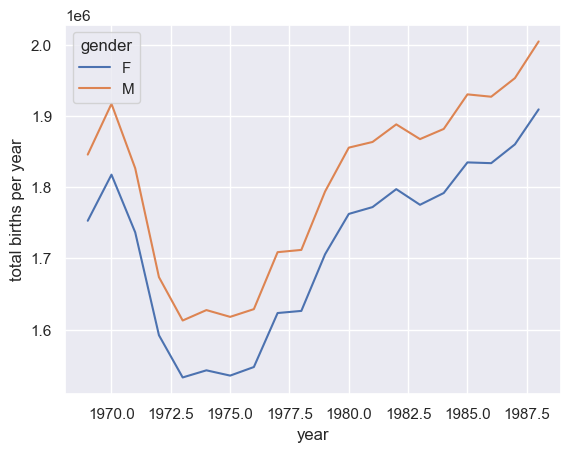

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

Con una simple tabla dinámica y el método ``plot()``, podemos ver inmediatamente la tendencia anual de los nacimientos por sexo. A simple vista, parece que en los últimos 50 años los nacimientos masculinos han superado a los femeninos en un 5% aproximadamente.

### Further data exploration

Aunque esto no está necesariamente relacionado con la tabla dinámica, hay algunas características más interesantes que podemos extraer de este conjunto de datos utilizando las herramientas de Pandas que hemos visto hasta ahora.
Debemos empezar por limpiar un poco los datos, eliminando los valores atípicos causados por fechas mal escritas (por ejemplo, 31 de junio) o valores que faltan (por ejemplo, 99 de junio).
Una forma sencilla de eliminarlos todos a la vez es cortar los valores atípicos; lo haremos mediante una operación robusta de recorte sigma:

In [69]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

Esta línea final es una estimación robusta de la media muestral, donde el 0,74 procede del rango intercuartílico de una distribución gaussiana.

Con esto podemos usar el método ``query()`` (discutido más adelante en [High-Performance Pandas: ``eval()`` and ``query()``](12_Performance-Eval-and-Query.ipynb)) para filtrar las filas con nacimientos fuera de estos valores:

In [70]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

A continuación, cambiamos la columna ``day`` a números enteros; antes era una cadena porque algunas columnas del conjunto de datos contenían el valor ``'null'``:

In [71]:
# cambia la columna 'day' a entero; originalmente era una cadena debido a los nulos
births['day'] = births['day'].astype(int)

Por último, podemos combinar el día, el mes y el año para crear un índice Fecha (véase [Trabajo con series temporales](11_Working-with-Time-Series.ipynb)).
Esto nos permite calcular rápidamente el día de la semana correspondiente a cada fila:

In [72]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

In [80]:
births

,year,month,day,gender,births,decade,dayofweek
1969-01-01,1969,1,1,F,4046,1960,2
1969-01-01,1969,1,1,M,4440,1960,2
1969-01-02,1969,1,2,F,4454,1960,3
1969-01-02,1969,1,2,M,4548,1960,3
1969-01-03,1969,1,3,F,4548,1960,4
...,...,...,...,...,...,...,...
1988-12-29,1988,12,29,M,5944,1980,3
1988-12-30,1988,12,30,F,5742,1980,4
1988-12-30,1988,12,30,M,6095,1980,4
1988-12-31,1988,12,31,F,4435,1980,5


De este modo, podemos trazar los nacimientos por día de la semana durante varias décadas:

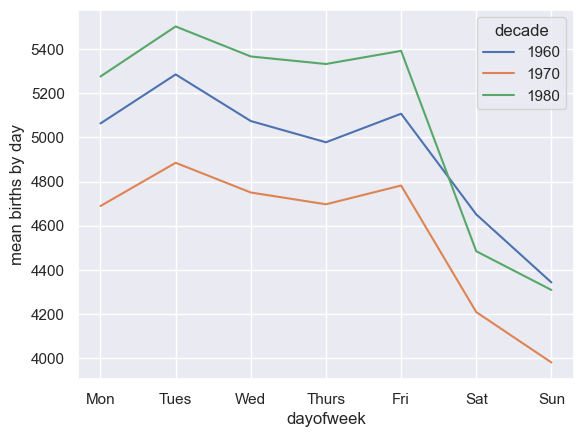

In [73]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
ax = plt.gca()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Al parecer, los nacimientos son ligeramente menos frecuentes los fines de semana que entre semana. Nótese que faltan los años 90 y 2000 porque los datos de los CDC sólo contienen el mes de nacimiento a partir de 1989.

Otra visión interesante es representar el número medio de nacimientos por día del *año*.
Agrupemos primero los datos por mes y día por separado:

In [84]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date

births
1  1   4009.225
   2   4247.400
   3   4500.900
   4   4571.350
   5   4603.625
...         ...
12 27  4850.150
   28  5044.200
   29  5120.150
   30  5172.350
   31  4859.200

[366 rows x 1 columns]

El resultado es un multiíndice de meses y días.
Para que sea más fácil de trazar, convirtamos estos meses y días en una fecha asociándolos a una variable de año ficticia (¡asegurándonos de elegir un año bisiesto para que el 29 de febrero se trate correctamente!)

In [82]:
from datetime import datetime
births_by_date.index = [datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Centrándonos sólo en el mes y el día, ahora tenemos una serie temporal que refleja el número medio de nacimientos por fecha del año.
A partir de aquí, podemos utilizar el método ``plot`` para representar gráficamente los datos. Esto revela algunas tendencias interesantes:

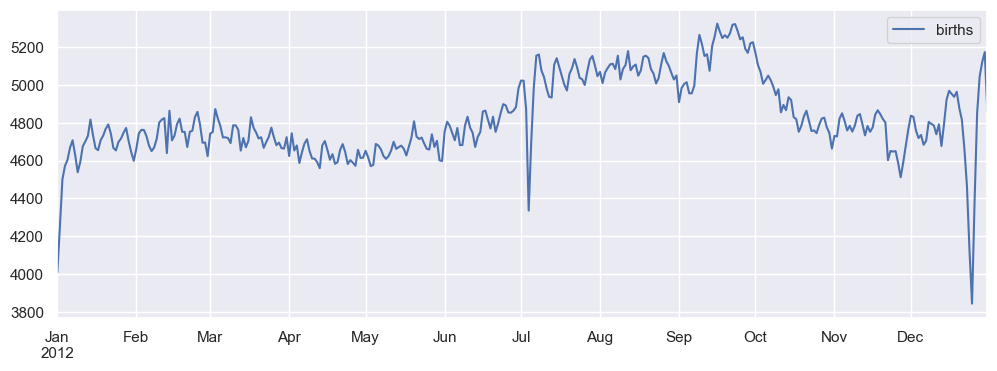

In [83]:
# Plot los resultados
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

En particular, la característica más llamativa de este gráfico es el descenso de la natalidad en los días festivos de EE.UU. (por ejemplo, el Día de la Independencia, el Día del Trabajo, Acción de Gracias, Navidad, Año Nuevo), aunque es probable que esto refleje tendencias en los nacimientos programados/inducidos más que algún profundo efecto psicosomático sobre los nacimientos naturales.

Este breve ejemplo muestra que muchas de las herramientas de Python y Pandas que hemos visto hasta ahora pueden combinarse y utilizarse para obtener información a partir de diversos conjuntos de datos.
Veremos algunas aplicaciones más sofisticadas de estas manipulaciones de datos en futuras secciones.